In [70]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from typing import List

In [32]:
glucose1 = pd.read_csv('sample_data/glucose_data_1.csv', header=None)
glucose2 = pd.read_csv('sample_data/glucose_data_2.csv', header=None)

scores1 = np.array(pd.read_csv('sample_data/scores_1.csv', header=None)).T
scores2 = np.array(pd.read_csv('sample_data/scores_2.csv', header=None)).T

In [99]:
def absolute_error(array1: np.array, array2: np.array) -> int:
  return np.sum(np.absolute(array1 - array2))

def print_errors(score_algorithm, dataset1, dataset2, original1, original2):
  print('For dataset 1:')
  scores = np.array(score_algorithm(dataset1))
  print('Abs. error: ' + str(absolute_error(scores, original1)))
  print('Avg. abs. error: ' + str(absolute_error(scores, original1) / 100))

  print('\n')
  print('For dataset 2:')
  scores_2 = np.array(score_algorithm(dataset2))
  print('Abs. error: ' + str(absolute_error(scores_2, original2)))
  print('Avg. abs. error: ' + str(absolute_error(scores_2, original2) / 100))

# Test 1: Product of relative changes

As first prototype I propose this algorithm:

1.   We will count the product of relative changes for each row (relative change is in range 0-1)
2.   Final score will be the product cieled


In [100]:
def generate_scores_v1(dataset: pd.DataFrame) -> List[int]:
  result: List[int] = []

  for i, row in dataset.iterrows():
    product: float = 1.0
    for j in range(0,9):
      if row[j] < row[j+1]:
        product *= (row[j]/row[j+1])
      else:
        product *= (row[j+1]/row[j])

    result.append(np.ceil(product * 10))
  
  return result

print_errors(generate_scores_v1, glucose1, glucose2, scores1, scores2)

For dataset 1:
Abs. error: 201.0
Avg. abs. error: 2.01


For dataset 2:
Abs. error: 188.0
Avg. abs. error: 1.88


# Test 2: Ratio between minimum and maximum

In this algorithm, we compute the ratio between maximum and minimum. As in no dataset this ratio is lower than 0.5, we will normalize the result from range 0.5 to 1 to 0 to 1, and then again ceil the resulting value (times 10)

In [101]:
def generate_scores_v2(dataset: pd.DataFrame) -> List[int]:
  result: List[int] = []

  for i, row in dataset.iterrows():
    ratio: float = np.min(row) / np.max(row)
    result.append(np.ceil((ratio - 0.5) * 20))
  
  return result

print_errors(generate_scores_v2, glucose1, glucose2, scores1, scores2)

For dataset 1:
Abs. error: 272.0
Avg. abs. error: 2.72


For dataset 2:
Abs. error: 232.0
Avg. abs. error: 2.32


# Test 3: Let's try mean of twe two scores

In [102]:
print('For dataset 1:')
scores_v3_1 = np.ceil((np.array(generate_scores_v2(glucose1)) + np.array(generate_scores_v1(glucose1))) / 2)
print('Abs. error: ' + str(absolute_error(np.array(scores_v3_1), scores1)))
print('Avg. abs. error: ' + str(absolute_error(np.array(scores_v3_1), scores1) / 100))

print('\n')
print('For dataset 2:')
scores_v3_2 = np.ceil((np.array(generate_scores_v2(glucose2)) + np.array(generate_scores_v1(glucose2))) / 2)
print('Abs. error: ' + str(absolute_error(np.array(scores_v3_2), scores2)))
print('Avg. abs. error: ' + str(absolute_error(np.array(scores_v3_2), scores2) / 100))

For dataset 1:
Abs. error: 203.0
Avg. abs. error: 2.03


For dataset 2:
Abs. error: 182.0
Avg. abs. error: 1.82


# Test 4: Stable 5 values and descending 5

What I have seen in the datasets, is that when the record has high score, usually the glucose levels are stable at first, and then either start to decrease or keep stable as well. So we will split this into two parts and combine the score



1.   We will count the standart deviation of first 5 items in the record, from that we will get score 0-5
2.   We will count how many times the level of glucose has decreased in last 5 items, for each decrease +1 point

In [103]:
def generate_scores_v4(dataset: pd.DataFrame) -> List[int]:
  result: List[int] = []

  for i, row in dataset.iterrows():
    score: int = 0
    stddev: float = np.std(row[0:5])
    score = 5 - min(np.floor(stddev * 5), 5)
    for j in range(4,9):
      if np.round(row[j],1) >= np.round(row[j+1],1): score += 1
    
    result.append(score)
  
  return result

print_errors(generate_scores_v4, glucose1, glucose2, scores1, scores2)

For dataset 1:
Abs. error: 118.0
Avg. abs. error: 1.18


For dataset 2:
Abs. error: 173.0
Avg. abs. error: 1.73


# Test 5: Try to use some tolerance

Now we will try to modify the algorithm from previous step, by adding the "tolerance" parameter, which will add the point in the second step even if there is a small difference.

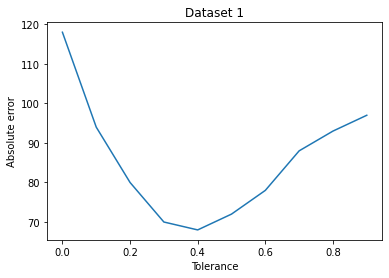

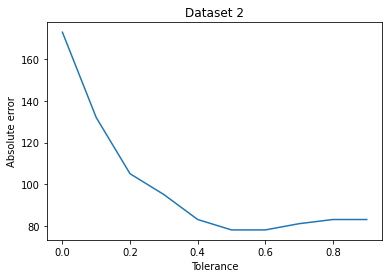

In [104]:
def generate_scores_v5(dataset: pd.DataFrame, tolerance: float) -> List[int]:
  result: List[int] = []

  for i, row in dataset.iterrows():
    score: int = 0
    stddev: float = np.std(row[0:5])
    score = 5 - min(np.floor(stddev * 5), 5)
    for j in range(4,9):
      if np.round(row[j],1) >= np.round(row[j+1] - tolerance,1): score += 1
    
    result.append(score)
  
  return result

x_axis = np.arange(0,1,0.1)
y_axis1 = []
y_axis2 = []

for i in x_axis:
  y_axis1.append( absolute_error(generate_scores_v5(glucose1, i), scores1) )
  y_axis2.append( absolute_error(generate_scores_v5(glucose2, i), scores2) )


plt.plot(x_axis, y_axis1)
plt.title('Dataset 1')
plt.xlabel('Tolerance')
plt.ylabel('Absolute error')
plt.show()

plt.plot(x_axis, y_axis2)
plt.title('Dataset 2')
plt.xlabel('Tolerance')
plt.ylabel('Absolute error')
plt.show()

We can see here, that the lowest error is there when the tolerance is around 0.4. We can try it here, hard-coded in our v4 function.

In [105]:
def generate_scores_v4_2(dataset: pd.DataFrame) -> List[int]:
  result: List[int] = []

  for i, row in dataset.iterrows():
    score: int = 0
    stddev: float = np.std(row[0:5])
    score = 5 - min(np.floor(stddev * 5), 5)
    for j in range(4,9):
      if np.round(row[j],1) >= np.round(row[j+1] - 0.4,1): score += 1
    result.append(score)
  
  return result

print_errors(generate_scores_v4_2, glucose1, glucose2, scores1, scores2)

For dataset 1:
Abs. error: 68.0
Avg. abs. error: 0.68


For dataset 2:
Abs. error: 83.0
Avg. abs. error: 0.83


But it may also indicate, that we are giving little amount of points in the first phase, opposed to how many we should be giving. Let's try to be more benevolent in the first phase, for example take the standard deviation as a minimum between standard deviation of first five values, and standard deviation between the same values without the first one. The goal is to reduce cases where the glucose goes up quickly (those cases also get greater amount of points)

# Test 6: Try standard deviation without the first value

We will try tolerance again after this

In [106]:
def generate_scores_v6(dataset: pd.DataFrame) -> List[int]:
  result: List[int] = []

  for i, row in dataset.iterrows():
    score: int = 0
    stddev: float = min(np.std(row[0:5]), np.std(row[1:5]))
    score = 5 - min(np.floor(stddev * 5), 5)
    for j in range(4,9):
      if np.round(row[j],1) >= np.round(row[j+1],1): score += 1
    
    result.append(score)
  
  return result

print_errors(generate_scores_v6, glucose1, glucose2, scores1, scores2)

For dataset 1:
Abs. error: 105.0
Avg. abs. error: 1.05


For dataset 2:
Abs. error: 156.0
Avg. abs. error: 1.56


Looks like we got better results, let's try to use tolerance again

# Test 7: Using tolerance again

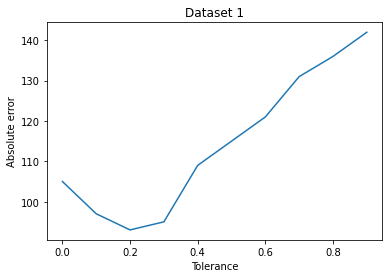

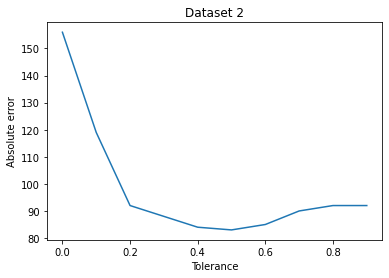

In [112]:
def generate_scores_v7(dataset: pd.DataFrame, tolerance: float) -> List[int]:
  result: List[int] = []

  for i, row in dataset.iterrows():
    score: int = 0
    stddev: float = min(np.std(row[0:5]), np.std(row[1:5]))
    score = 5 - min(np.floor(stddev * 5), 5)
    for j in range(4,9):
      if np.round(row[j],1) >= np.round(row[j+1] - tolerance,1): score += 1
    
    result.append(score)
  
  return result

x_axis = np.arange(0,1,0.1)
y_axis1 = []
y_axis2 = []

for i in x_axis:
  y_axis1.append( absolute_error(generate_scores_v7(glucose1, i), scores1) )
  y_axis2.append( absolute_error(generate_scores_v7(glucose2, i), scores2) )


plt.plot(x_axis, y_axis1)
plt.title('Dataset 1')
plt.xlabel('Tolerance')
plt.ylabel('Absolute error')
plt.show()

plt.plot(x_axis, y_axis2)
plt.title('Dataset 2')
plt.xlabel('Tolerance')
plt.ylabel('Absolute error')
plt.show()

This looks more logical with the tolerance somewhere about 0.2 in the first dataset, from 0.2 it looks stable in the second one. Let's try it hard-coded

In [113]:
def generate_scores_v6_2(dataset: pd.DataFrame) -> List[int]:
  result: List[int] = []

  for i, row in dataset.iterrows():
    score: int = 0
    stddev: float = min(np.std(row[0:5]), np.std(row[1:5]))
    score = 5 - min(np.floor(stddev * 5), 5)
    for j in range(4,9):
      if np.round(row[j],1) >= np.round(row[j+1] - 0.2,1): score += 1
    
    result.append(score)
  
  return result

print_errors(generate_scores_v6_2, glucose1, glucose2, scores1, scores2)

For dataset 1:
Abs. error: 93.0
Avg. abs. error: 0.93


For dataset 2:
Abs. error: 92.0
Avg. abs. error: 0.92


And also in both cases the absolute error is similar.